In [7]:
#-*- coding: latin1 -*-
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.layers import BatchNormalization

plt.rcParams['figure.figsize'] = [15, 10]

# Description

- CIFAR-10 jest zbiorem zawierającym 60.000 zdjęć, każde w rozmiarach 32x32 pikseli. Zdjęcia można podzielić na 10 klas (6000 zdjęć każdej klasy). Zbiór uczący składa się z 50.000 instancji, zbiór testowy z 10.000.
- Instancje podzielone są na 5 batchy uczących i 1 testujący. Każdy batch zawiera 10.000 zdjęć.
- Pojedynczy batch zawiera 1000 losowo wybranych zdjęć z każdej klasy.
- Klasy zdjęć:  
  - airplane
  - automobile
  - bird
  - cat
  - deer
  - dog
  - frog
  - horse
  - ship
  - truck

Używany w dalszej części projektu termin "skuteczność klasyfikacji" oznacza stosunek poprawnie sklasyfikowanych obrazów zbioru testowego, w stosunku do całkowitej liczby elementów w tym zbiorze pomnożony przez 100%. Przykładowo "skuteczność 80%" oznacza, że w 80%-tach przypadków sieć poprawnie sklasyfikowała wybrany obraz znajdujący się w zbiorze testowym.

Używany w dalszej części projektu termin "epoka" lub "iteracja" oznacza proces przetworzenia wszystkich elementów zbioru uczącego.

# Helper functions

In [8]:
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    
    # one hot encode target values (transform integer into a 10 element binary vector with a a1 for the class index of the value)
    trainY = np_utils.to_categorical(trainY)
    testY = np_utils.to_categorical(testY)
    return trainX, trainY, testX, testY


# scale pixels
def scale_pixels(train, test):
    # convert: integers -> float32
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    # return normalized images
    return train_norm, test_norm


# plot diagnostic learning curves
def show_summary(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['acc'], color='blue', label='train')
    plt.plot(history.history['val_acc'], color='orange', label='test')

    
# run test
def run_test(mod, iterations = None):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    
    # scale pixels
    trainX, testX = scale_pixels(trainX, testX)
    
    if iterations is None:
        iterations = 100
    
    # fit model
    history = mod.fit(trainX, trainY, 
                        epochs = iterations, 
                        batch_size = 64, 
                        validation_data = (testX, testY), 
                        verbose = 1)

    # evaluate model
    _, acc = mod.evaluate(testX, testY, verbose = 0)

    # print accuracy
    print('Accuracy (on testing set): > %.3f' % (acc * 100.0))
    
    # return history
    return history

# Load the dataset

In [9]:
# load the dataset
trainX, trainY, testX, testY = load_dataset()

# dataset summary
print('Training data: X = %s, y = %s' % (trainX.shape, trainY.shape))
print('Testing data: X = %s, y = %s' % (testX.shape, testY.shape))

Training data: X = (50000, 32, 32, 3), y = (50000, 10)
Testing data: X = (10000, 32, 32, 3), y = (10000, 10)


# Show example images

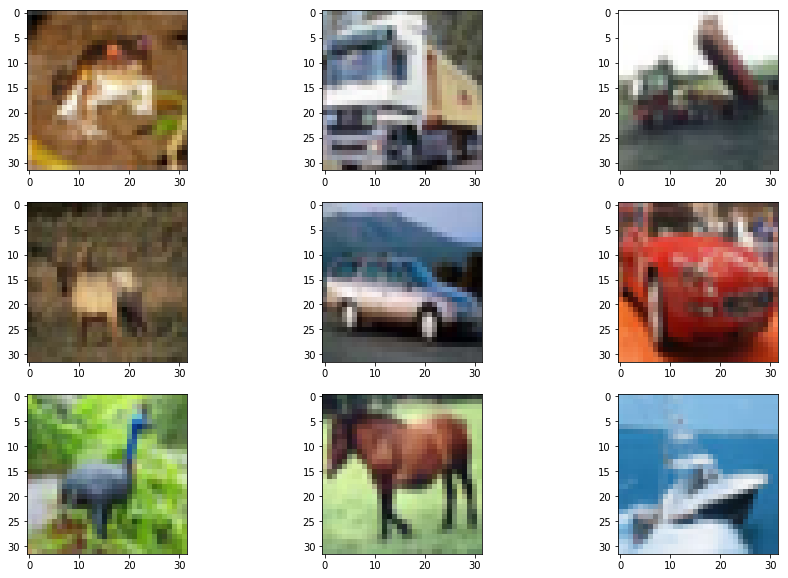

In [10]:
# plot sample images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i])
plt.show()

# Prepare pixel data

In [11]:
trainX, trainY = scale_pixels(trainX, trainY)

# Define base model (1 VGG block)

Na początku zdefiniowano podstawowy model VGG, który składa się z:
- (1) dwóch warstw konwolucyjnych o rozmiarach 3x3,
- (2) jednej warstwy dokonującej max-pooling,
- (3) dwóch warstw w pełni połączonych

Warstwy (1) i (2) tworzą pewnego rodzaju "blok", który może być powielany, przy czym liczba filtrów w każdym bloku będzie wzrastała dwukrotnie wraz z każdym kolejnym blokiem.

Padding został użyty na warstwach konwolucyjnych po to, by upewnić się, że rozmiary warstw wyjściowych będą takie same jak rozmiary warstwy wejściowej.

Użytym algorytmem optymalizującym był SGD (Stochastic Gradient Descent)

In [12]:
# define cnn model
def define_model_v1():
    # create sequential model
    model = Sequential()
    
    # add convolution
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # flatten (flattens input into a single vector)
    model.add(Flatten())
    
    # fully connected layer (128 units, ReLU activation function)
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # fully connected layer (10 units, softmax activation function)
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr = 0.001, momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

model = define_model_v1()

# run test
history = run_test(model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 151us/step - loss: 1.7489 - acc: 0.3795 - val_loss: 1.5332 - val_acc: 0.4470
Epoch 2/100
50000/50000 [==============================] - 7s 135us/step - loss: 1.4101 - acc: 0.5001 - val_loss: 1.3107 - val_acc: 0.5344
Epoch 3/100
50000/50000 [==============================] - 7s 133us/step - loss: 1.2587 - acc: 0.5575 - val_loss: 1.2243 - val_acc: 0.5693
Epoch 4/100
50000/50000 [==============================] - 7s 133us/step - loss: 1.1616 - acc: 0.5924 - val_loss: 1.1778 - val_acc: 0.5843
Epoch 5/100
50000/50000 [==============================] - 7s 132us/step - loss: 1.0791 - acc: 0.6213 - val_loss: 1.1190 - val_acc: 0.6081
Epoch 6/100
50000/50000 [==============================] - 7s 136us/step - loss: 1.0149 - acc: 0.6438 - val_loss: 1.0950 - val_acc: 0.6106
Epoch 7/100
50000/50000 [==============================] - 7s 137us/step - loss: 0.9537 - acc: 0.6673 - val_loss: 1.

50000/50000 [==============================] - 7s 130us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 2.2881 - val_acc: 0.6616
Epoch 60/100
50000/50000 [==============================] - 7s 132us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 2.2915 - val_acc: 0.6625
Epoch 61/100
50000/50000 [==============================] - 7s 130us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 2.3022 - val_acc: 0.6633
Epoch 62/100
50000/50000 [==============================] - 6s 129us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 2.3099 - val_acc: 0.6627
Epoch 63/100
50000/50000 [==============================] - 6s 130us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 2.3203 - val_acc: 0.6617
Epoch 64/100
50000/50000 [==============================] - 7s 135us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 2.3261 - val_acc: 0.6624
Epoch 65/100
50000/50000 [==============================] - 7s 141us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 2.3330 - val_acc: 0.6620
Epoch 66/100
50000/50000 [=======

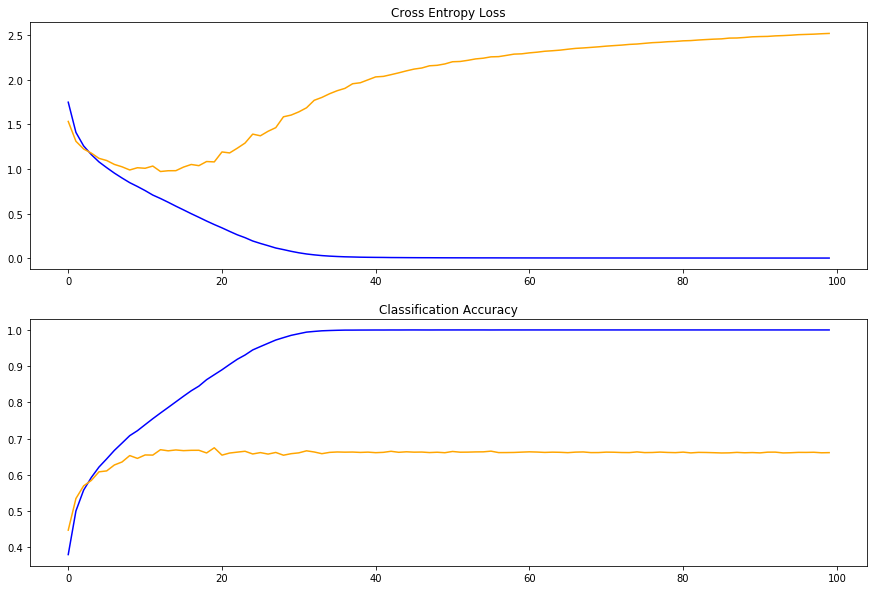

In [13]:
# show summary
show_summary(history)

Jak widać powyżej, sieć neuronowa oparta o model zbudowany z jednego bloku VGG przeprowadziła poprawną klasyfikację obrazu w 66.6%. Jest to dobry wynik, zważając na to, że zbiór zawiera aż 10 różnych klas, więc prawdopodobieństwo trafienia "na ślepo" wynosi 10%.

Jak widać na powyższych wykresach, dość szybko następuje zjawisko przeuczenia i już po 15 iteracjach wartość funkcji straty dla danych testowych zaczyna gwałtownie rosnąć, pomimo że skuteczność klasyfikacji sieci dla danych ze zbioru uczącego wynosi w tym czasie dopiero ok. 85%.

Najlepsze wyniki dla tego zbioru danych uzyskiwane przy użyciu konwolucyjnych sieci neuronowych wynosiły ponad 90%. Jest to wynik znacznie większy, niż ten uzyskany powyżej, dlatego w kolejnych etapach projektu zwiększono liczbę bloków VGG i zbadano ich wpływ na skuteczność klasyfikacji.

# Define modified model (with 2 VGG blocks)

W kolejnej części projektu zmodyfikowano poprzedni model, dodając do niego kolejny blok VGG i porównano wyniki. Jak wspomnianio wcześniej, podczas dokładania kolejnych bloków VGG, liczba zastosowanych filtrów będzie zwiększana dwukrotnie z każdym dodanym blokiem.

In [14]:
# define cnn model
def define_model_v2():
    # create sequential model
    model = Sequential()
    
    # add convolution (1st VGG block)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # add convolution (2st VGG block)
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # flatten (flattens input into a single vector)
    model.add(Flatten())
    
    # fully connected layer (128 units, ReLU activation function)
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # fully connected layer (10 units, softmax activation function)
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr = 0.001, momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

model = define_model_v2()

# run test
history = run_test(model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 183us/step - loss: 1.7455 - acc: 0.3776 - val_loss: 1.5036 - val_acc: 0.4490
Epoch 2/100
50000/50000 [==============================] - 8s 159us/step - loss: 1.3420 - acc: 0.5203 - val_loss: 1.2385 - val_acc: 0.5657
Epoch 3/100
50000/50000 [==============================] - 8s 158us/step - loss: 1.1724 - acc: 0.5833 - val_loss: 1.1507 - val_acc: 0.5923
Epoch 4/100
50000/50000 [==============================] - 8s 158us/step - loss: 1.0461 - acc: 0.6322 - val_loss: 1.0728 - val_acc: 0.6256
Epoch 5/100
50000/50000 [==============================] - 8s 156us/step - loss: 0.9623 - acc: 0.6624 - val_loss: 1.0281 - val_acc: 0.6419
Epoch 6/100
50000/50000 [==============================] - 8s 165us/step - loss: 0.8945 - acc: 0.6873 - val_loss: 0.9838 - val_acc: 0.6561
Epoch 7/100
50000/50000 [==============================] - 8s 167us/step - loss: 0.8313 - acc: 0.7105 - val_loss: 0.

Epoch 59/100
50000/50000 [==============================] - 8s 158us/step - loss: 4.5836e-04 - acc: 1.0000 - val_loss: 2.3458 - val_acc: 0.7100
Epoch 60/100
50000/50000 [==============================] - 8s 160us/step - loss: 4.4228e-04 - acc: 1.0000 - val_loss: 2.3533 - val_acc: 0.7100
Epoch 61/100
50000/50000 [==============================] - 8s 152us/step - loss: 4.2881e-04 - acc: 1.0000 - val_loss: 2.3590 - val_acc: 0.7110
Epoch 62/100
50000/50000 [==============================] - 8s 151us/step - loss: 4.1484e-04 - acc: 1.0000 - val_loss: 2.3666 - val_acc: 0.7102
Epoch 63/100
50000/50000 [==============================] - 8s 150us/step - loss: 4.0406e-04 - acc: 1.0000 - val_loss: 2.3694 - val_acc: 0.7101
Epoch 64/100
50000/50000 [==============================] - 7s 149us/step - loss: 3.9114e-04 - acc: 1.0000 - val_loss: 2.3755 - val_acc: 0.7097
Epoch 65/100
50000/50000 [==============================] - 7s 149us/step - loss: 3.7895e-04 - acc: 1.0000 - val_loss: 2.3801 - val_acc:

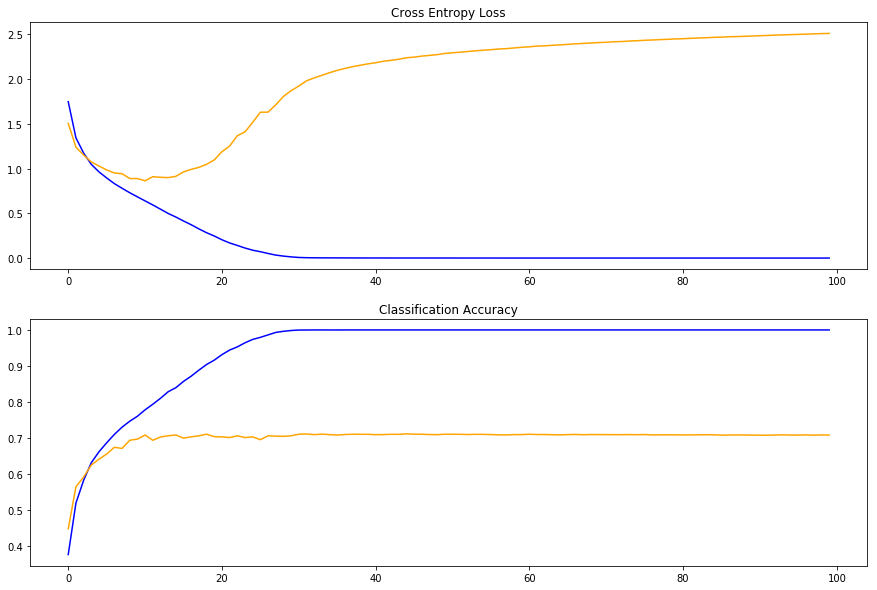

In [15]:
# show summary
show_summary(history)

Jak widać powyżej, rozbudowanie modelu o jeden blok VGG nieznacznie zwiększył skuteczność sieci (do ok. 71%), jednak nadal dosyć szybko pojawia się zjawisko przeuczenia.

W kolejnym etapie do sieci dodano jeszcze jeden blok i zbadano, czy skuteczność wykrywania ponownie się polepszy.

# Define modified model (with 3 VGG blocks)

In [16]:
# define cnn model
def define_model_v3():
    # create sequential model
    model = Sequential()
    
    # add convolution (1st VGG block)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # add convolution (2st VGG block)
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # add convolution (3st VGG block)
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # flatten (flattens input into a single vector)
    model.add(Flatten())
    
    # fully connected layer (128 units, ReLU activation function)
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # fully connected layer (10 units, softmax activation function)
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr = 0.001, momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

model = define_model_v3()

# run test
history = run_test(model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 212us/step - loss: 1.6998 - acc: 0.3869 - val_loss: 1.4780 - val_acc: 0.4526
Epoch 2/100
50000/50000 [==============================] - 9s 183us/step - loss: 1.3582 - acc: 0.5176 - val_loss: 1.2434 - val_acc: 0.5621
Epoch 3/100
50000/50000 [==============================] - 9s 177us/step - loss: 1.1844 - acc: 0.5822 - val_loss: 1.1404 - val_acc: 0.5948
Epoch 4/100
50000/50000 [==============================] - 9s 176us/step - loss: 1.0588 - acc: 0.6272 - val_loss: 1.1231 - val_acc: 0.6145
Epoch 5/100
50000/50000 [==============================] - 9s 178us/step - loss: 0.9558 - acc: 0.6655 - val_loss: 1.0058 - val_acc: 0.6473
Epoch 6/100
50000/50000 [==============================] - 9s 181us/step - loss: 0.8730 - acc: 0.6977 - val_loss: 0.9909 - val_acc: 0.6504
Epoch 7/100
50000/50000 [==============================] - 9s 180us/step - loss: 0.7991 - acc: 0.7229 - val_loss: 0

Epoch 59/100
50000/50000 [==============================] - 9s 179us/step - loss: 8.5475e-05 - acc: 1.0000 - val_loss: 2.1874 - val_acc: 0.7362
Epoch 60/100
50000/50000 [==============================] - 9s 174us/step - loss: 8.2185e-05 - acc: 1.0000 - val_loss: 2.1913 - val_acc: 0.7370
Epoch 61/100
50000/50000 [==============================] - 9s 174us/step - loss: 7.9152e-05 - acc: 1.0000 - val_loss: 2.1962 - val_acc: 0.7370
Epoch 62/100
50000/50000 [==============================] - 9s 174us/step - loss: 7.6322e-05 - acc: 1.0000 - val_loss: 2.2006 - val_acc: 0.7372
Epoch 63/100
50000/50000 [==============================] - 9s 176us/step - loss: 7.3882e-05 - acc: 1.0000 - val_loss: 2.2043 - val_acc: 0.7373
Epoch 64/100
50000/50000 [==============================] - 9s 182us/step - loss: 7.1451e-05 - acc: 1.0000 - val_loss: 2.2089 - val_acc: 0.7376
Epoch 65/100
50000/50000 [==============================] - 9s 175us/step - loss: 6.9154e-05 - acc: 1.0000 - val_loss: 2.2124 - val_acc:

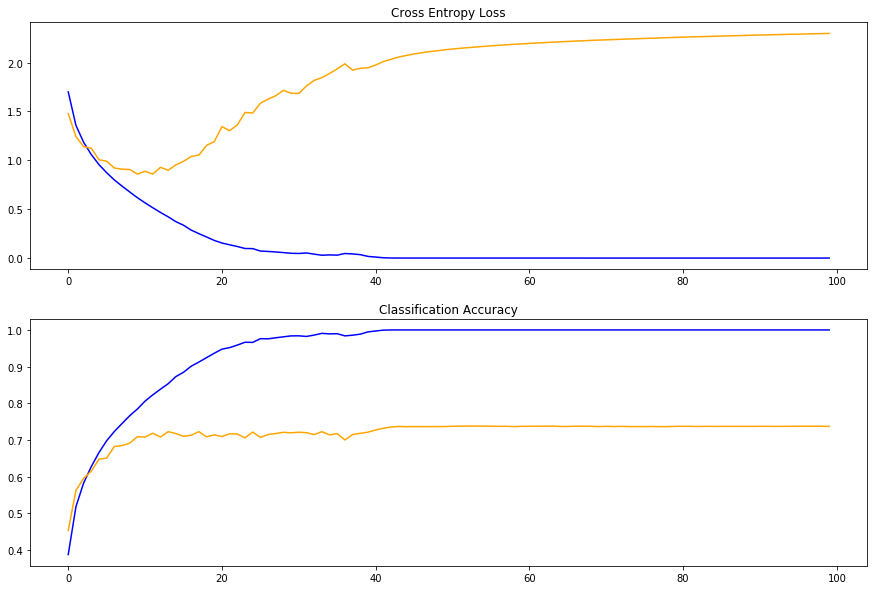

In [17]:
# show summary
show_summary(history)

Skuteczność sieci z trzema blokami VGG wynosi ok. 74%, jednak ciągle widoczne jest tu zjawisko przeuczenia, które występuje już po niecałych 20-tu iteracjach.

# Define improved model (with 3 VGG + dropout)

W kolejnym etapie projektu dodano do poprzedniej sieci "Dropout", który polega na usuwaniu pewnych połączeń pomiędzy neuronami w sieci, z pewnym prawdopodobieństwem. Zabieg ten ma na celu obniżenie wrażliwości modelu na przeuczenie. Jest to forma regularyzacji modelu. Dzięki zastosowaniu warstwy "Dropout", sieć będzie starała się dostrzegać niezależne cechy i brak jednej z nich nie będzie wtedy problemem. Powinno to znacznie obniżyć podatność sieci na przeuczenie.

Model z punktu wyżej zmodyfikowano poprzez dodanie warstw "Dropout" po każdym poolingu oraz po warstwie w pełni połączonej. "Dropout rate" ustawiony został na 20% (usuwane jest 20% połączeń).

In [18]:
# define cnn model
def define_model_v3_dropout():
    # create sequential model
    model = Sequential()
    
    # add convolution (1st VGG block)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # add dropout
    model.add(Dropout(0.2))
    
    # add convolution (2st VGG block)
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # add dropout
    model.add(Dropout(0.2))
    
    # add convolution (3st VGG block)
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    
    # add pooling
    model.add(MaxPooling2D((2, 2)))
    
    # add dropout
    model.add(Dropout(0.2))
    
    # flatten (flattens input into a single vector)
    model.add(Flatten())
    
    # fully connected layer (128 units, ReLU activation function)
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # add dropout
    model.add(Dropout(0.2))
    
    # fully connected layer (10 units, softmax activation function)
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr = 0.001, momentum = 0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

model = define_model_v3_dropout()

# run test
history = run_test(model)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 213us/step - loss: 2.0541 - acc: 0.2364 - val_loss: 1.7340 - val_acc: 0.3837
Epoch 2/100
50000/50000 [==============================] - 9s 187us/step - loss: 1.6926 - acc: 0.3727 - val_loss: 1.5309 - val_acc: 0.4379
Epoch 3/100
50000/50000 [==============================] - 10s 193us/step - loss: 1.5463 - acc: 0.4319 - val_loss: 1.4282 - val_acc: 0.4797
Epoch 4/100
50000/50000 [==============================] - 9s 190us/step - loss: 1.4361 - acc: 0.4736 - val_loss: 1.3035 - val_acc: 0.5270
Epoch 5/100
50000/50000 [==============================] - 9s 185us/step - loss: 1.3479 - acc: 0.5099 - val_loss: 1.2715 - val_acc: 0.5358
Epoch 6/100
50000/50000 [==============================] - 9s 185us/step - loss: 1.2810 - acc: 0.5380 - val_loss: 1.2009 - val_acc: 0.5677
Epoch 7/100
50000/50000 [==============================] - 9s 181us/step - loss: 1.2130 - acc: 0.5632 - val_loss: 

50000/50000 [==============================] - 9s 178us/step - loss: 0.4226 - acc: 0.8487 - val_loss: 0.5544 - val_acc: 0.8176
Epoch 60/100
50000/50000 [==============================] - 9s 181us/step - loss: 0.4175 - acc: 0.8503 - val_loss: 0.5547 - val_acc: 0.8197
Epoch 61/100
50000/50000 [==============================] - 9s 177us/step - loss: 0.4085 - acc: 0.8542 - val_loss: 0.5671 - val_acc: 0.8173
Epoch 62/100
50000/50000 [==============================] - 9s 176us/step - loss: 0.4057 - acc: 0.8556 - val_loss: 0.5436 - val_acc: 0.8180
Epoch 63/100
50000/50000 [==============================] - 9s 181us/step - loss: 0.3968 - acc: 0.8583 - val_loss: 0.5536 - val_acc: 0.8186
Epoch 64/100
50000/50000 [==============================] - 9s 179us/step - loss: 0.3957 - acc: 0.8581 - val_loss: 0.5747 - val_acc: 0.8094
Epoch 65/100
50000/50000 [==============================] - 9s 181us/step - loss: 0.3933 - acc: 0.8601 - val_loss: 0.5693 - val_acc: 0.8110
Epoch 66/100
50000/50000 [=======

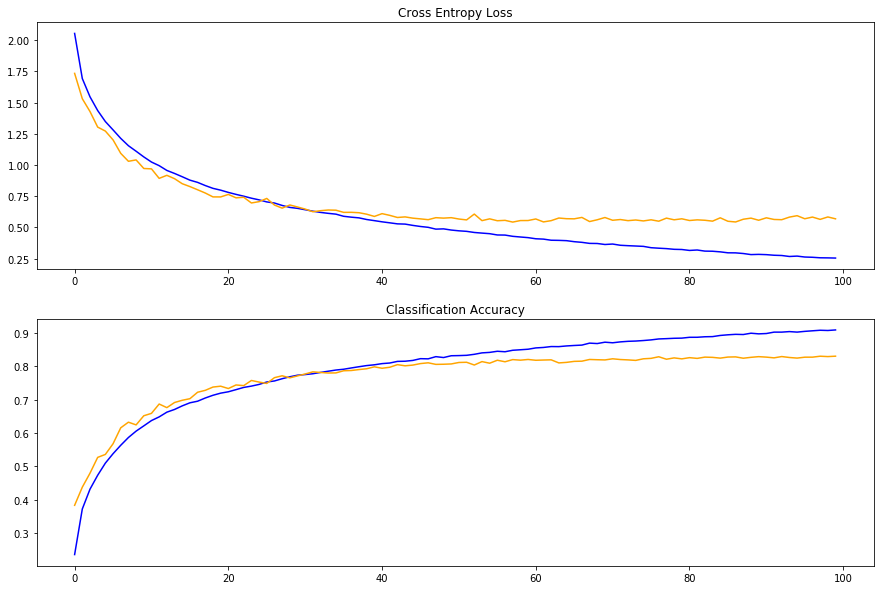

In [19]:
# show summary
show_summary(history)

Jak widać powyżej, dodanie "Dropout"'ów znacznie poprawiło skuteczność sieci dla danych testowych (ok. 83%), a zjawisko przeuczenia sieci jest już praktycznie niewidoczne. 

# Define improved model (with 3 VGG + dropout + batch normalization)

Przy każdym poprzednim modelu, sieć trenowana była w 100 iteracjach (epokach). W następnym etapie projektu zwiększono tę liczbę, by sprawdzić czy model będzie w stanie jeszcze bardziej zwiększyć swoją dokładność.

W poprzednim punkcie zlikwidowane zostało zjawisko overfittingu i wartość funkcji straty nie rośnie nawet w setnej epoce, dlatego można bezpiecznie zwiększyć ilość iteracji i sprawdzić jak zachowa się model.

W celu przyspieszenia procesu nauki przy zwiększonej liczbie epok, zastosowano normalizację batch'u. Normalizacja batch'u jest techniką, która przyspiesza proces nauki i zwiększa jej stabilność. Używana jest to normalizacji warstwy wejściowej poprzez regulację i skalowanie funkcji aktywacji.

W celu zwiększenia regularyzacji, zwiększano również stopiniowo wartość "Dropout"'u w każdej warstwie.

Liczbę epok zwiększono do 400.

In [5]:
# define cnn model
def define_model_v3_dropout_normalization():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model_v3_dropout_normalization()

# run test
history = run_test(model, 400)

Train on 50000 samples, validate on 10000 samples
Epoch 1/400
50000/50000 [==============================] - 18s 358us/step - loss: 2.0822 - acc: 0.3075 - val_loss: 1.5611 - val_acc: 0.4251
Epoch 2/400
50000/50000 [==============================] - 16s 324us/step - loss: 1.5719 - acc: 0.4256 - val_loss: 1.5515 - val_acc: 0.4383
Epoch 3/400
50000/50000 [==============================] - 16s 313us/step - loss: 1.4272 - acc: 0.4800 - val_loss: 1.3765 - val_acc: 0.5060
Epoch 4/400
50000/50000 [==============================] - 15s 310us/step - loss: 1.3288 - acc: 0.5168 - val_loss: 1.2455 - val_acc: 0.5515
Epoch 5/400
50000/50000 [==============================] - 16s 316us/step - loss: 1.2521 - acc: 0.5469 - val_loss: 1.1768 - val_acc: 0.5796
Epoch 6/400
50000/50000 [==============================] - 16s 311us/step - loss: 1.1966 - acc: 0.5695 - val_loss: 1.1253 - val_acc: 0.5967
Epoch 7/400
50000/50000 [==============================] - 16s 320us/step - loss: 1.1435 - acc: 0.5907 - val_l

Epoch 59/400
50000/50000 [==============================] - 16s 325us/step - loss: 0.5107 - acc: 0.8230 - val_loss: 0.5543 - val_acc: 0.8122
Epoch 60/400
50000/50000 [==============================] - 16s 322us/step - loss: 0.5098 - acc: 0.8216 - val_loss: 0.5929 - val_acc: 0.7966
Epoch 61/400
50000/50000 [==============================] - 16s 320us/step - loss: 0.5013 - acc: 0.8253 - val_loss: 0.5655 - val_acc: 0.8043
Epoch 62/400
50000/50000 [==============================] - 16s 324us/step - loss: 0.4980 - acc: 0.8261 - val_loss: 0.5476 - val_acc: 0.8128
Epoch 63/400
50000/50000 [==============================] - 16s 323us/step - loss: 0.4907 - acc: 0.8316 - val_loss: 0.5147 - val_acc: 0.8228
Epoch 64/400
50000/50000 [==============================] - 16s 321us/step - loss: 0.4872 - acc: 0.8313 - val_loss: 0.5300 - val_acc: 0.8234
Epoch 65/400
50000/50000 [==============================] - 16s 328us/step - loss: 0.4796 - acc: 0.8330 - val_loss: 0.5438 - val_acc: 0.8173
Epoch 66/400


Epoch 117/400
50000/50000 [==============================] - 15s 307us/step - loss: 0.3184 - acc: 0.8892 - val_loss: 0.4862 - val_acc: 0.8447
Epoch 118/400
50000/50000 [==============================] - 15s 303us/step - loss: 0.3174 - acc: 0.8889 - val_loss: 0.4592 - val_acc: 0.8532
Epoch 119/400
50000/50000 [==============================] - 16s 319us/step - loss: 0.3185 - acc: 0.8884 - val_loss: 0.5168 - val_acc: 0.8373
Epoch 120/400
50000/50000 [==============================] - 16s 320us/step - loss: 0.3162 - acc: 0.8889 - val_loss: 0.4994 - val_acc: 0.8445
Epoch 121/400
50000/50000 [==============================] - 16s 319us/step - loss: 0.3121 - acc: 0.8895 - val_loss: 0.4632 - val_acc: 0.8507
Epoch 122/400
50000/50000 [==============================] - 16s 326us/step - loss: 0.3086 - acc: 0.8921 - val_loss: 0.4668 - val_acc: 0.8518
Epoch 123/400
50000/50000 [==============================] - 16s 326us/step - loss: 0.3033 - acc: 0.8929 - val_loss: 0.4643 - val_acc: 0.8533
Epoch 

Epoch 175/400
50000/50000 [==============================] - 15s 299us/step - loss: 0.2236 - acc: 0.9191 - val_loss: 0.4628 - val_acc: 0.8618
Epoch 176/400
50000/50000 [==============================] - 15s 296us/step - loss: 0.2184 - acc: 0.9238 - val_loss: 0.4668 - val_acc: 0.8620
Epoch 177/400
50000/50000 [==============================] - 15s 304us/step - loss: 0.2217 - acc: 0.9214 - val_loss: 0.4712 - val_acc: 0.8604
Epoch 178/400
50000/50000 [==============================] - 15s 306us/step - loss: 0.2209 - acc: 0.9218 - val_loss: 0.4797 - val_acc: 0.8646
Epoch 179/400
50000/50000 [==============================] - 15s 309us/step - loss: 0.2183 - acc: 0.9242 - val_loss: 0.4929 - val_acc: 0.8585
Epoch 180/400
50000/50000 [==============================] - 15s 304us/step - loss: 0.2145 - acc: 0.9237 - val_loss: 0.4673 - val_acc: 0.8613
Epoch 181/400
50000/50000 [==============================] - 15s 302us/step - loss: 0.2152 - acc: 0.9233 - val_loss: 0.4667 - val_acc: 0.8652
Epoch 

Epoch 233/400
50000/50000 [==============================] - 15s 303us/step - loss: 0.1723 - acc: 0.9396 - val_loss: 0.4903 - val_acc: 0.8675
Epoch 234/400
50000/50000 [==============================] - 15s 300us/step - loss: 0.1698 - acc: 0.9398 - val_loss: 0.4931 - val_acc: 0.8646
Epoch 235/400
50000/50000 [==============================] - 15s 303us/step - loss: 0.1682 - acc: 0.9418 - val_loss: 0.5028 - val_acc: 0.8632
Epoch 236/400
50000/50000 [==============================] - 15s 291us/step - loss: 0.1657 - acc: 0.9411 - val_loss: 0.4848 - val_acc: 0.8651
Epoch 237/400
50000/50000 [==============================] - 14s 286us/step - loss: 0.1643 - acc: 0.9423 - val_loss: 0.4903 - val_acc: 0.8677
Epoch 238/400
50000/50000 [==============================] - 15s 291us/step - loss: 0.1665 - acc: 0.9426 - val_loss: 0.4968 - val_acc: 0.8629
Epoch 239/400
50000/50000 [==============================] - 15s 299us/step - loss: 0.1669 - acc: 0.9422 - val_loss: 0.4975 - val_acc: 0.8639
Epoch 

Epoch 291/400
50000/50000 [==============================] - 14s 286us/step - loss: 0.1375 - acc: 0.9521 - val_loss: 0.5165 - val_acc: 0.8640
Epoch 292/400
50000/50000 [==============================] - 14s 287us/step - loss: 0.1381 - acc: 0.9517 - val_loss: 0.5348 - val_acc: 0.8624
Epoch 293/400
50000/50000 [==============================] - 14s 287us/step - loss: 0.1370 - acc: 0.9527 - val_loss: 0.5055 - val_acc: 0.8674
Epoch 294/400
50000/50000 [==============================] - 14s 286us/step - loss: 0.1395 - acc: 0.9509 - val_loss: 0.5035 - val_acc: 0.8693
Epoch 295/400
50000/50000 [==============================] - 14s 287us/step - loss: 0.1367 - acc: 0.9520 - val_loss: 0.5205 - val_acc: 0.8692
Epoch 296/400
50000/50000 [==============================] - 14s 282us/step - loss: 0.1352 - acc: 0.9525 - val_loss: 0.5171 - val_acc: 0.8675
Epoch 297/400
50000/50000 [==============================] - 14s 284us/step - loss: 0.1333 - acc: 0.9548 - val_loss: 0.5608 - val_acc: 0.8578
Epoch 

Epoch 349/400
50000/50000 [==============================] - 14s 289us/step - loss: 0.1177 - acc: 0.9577 - val_loss: 0.5083 - val_acc: 0.8725
Epoch 350/400
50000/50000 [==============================] - 14s 287us/step - loss: 0.1184 - acc: 0.9595 - val_loss: 0.5082 - val_acc: 0.8733
Epoch 351/400
50000/50000 [==============================] - 15s 297us/step - loss: 0.1153 - acc: 0.9608 - val_loss: 0.5279 - val_acc: 0.8681
Epoch 352/400
50000/50000 [==============================] - 15s 296us/step - loss: 0.1128 - acc: 0.9606 - val_loss: 0.5187 - val_acc: 0.8723
Epoch 353/400
50000/50000 [==============================] - 14s 283us/step - loss: 0.1149 - acc: 0.9592 - val_loss: 0.5307 - val_acc: 0.8711
Epoch 354/400
50000/50000 [==============================] - 15s 301us/step - loss: 0.1169 - acc: 0.9591 - val_loss: 0.5110 - val_acc: 0.8725
Epoch 355/400
50000/50000 [==============================] - 14s 282us/step - loss: 0.1164 - acc: 0.9593 - val_loss: 0.5124 - val_acc: 0.8710
Epoch 

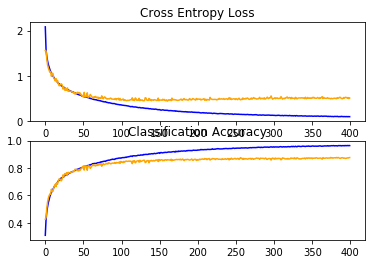

In [6]:
# show summary
show_summary(history)